In [108]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, os.path.abspath(os.path.join(os.path.abspath(''), '..')))

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import scipy.signal
from collections import defaultdict
import hydracv.utils.utils as utils
import hydracv.disp as disp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pipeline

0. Extract the fluorescence traces from each video
1. Divide CB periods based on peak clusters
2. Extract periods and count the number of CB spikes
3. Align all pieces by setting the length of the starting point (contracted) as 1
4. Plot the relationship between elongated length and the number of prior CB spikes 

In [3]:
results = defaultdict(lambda:[])

In [226]:
VIDEONAME = "EndoRCaMP_ctrl_30mins_35x_10fps_79%intensity_mv6"
VIDEOFPS = 5
ORIGFPS = 10

### Load and normalize fluorescence data

In [227]:
FLUODIR = "./data/fluorescence/"
FLUONAME = "total_fluo_" + VIDEONAME + ".csv"

In [228]:
# Load fluorescence data
fluo = pd.read_csv(FLUODIR + FLUONAME).values.reshape(-1)
minfluo = min(fluo)
maxfluo = max(fluo)
fluo = [(x -minfluo) / (maxfluo - minfluo) for x in fluo]

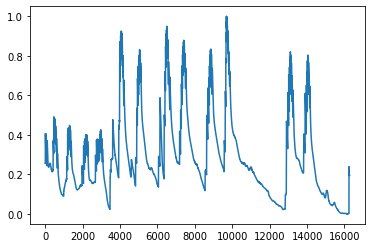

In [229]:
plt.plot(fluo)

### Detect and cluster CB spikes

In [230]:
# Detect peaks
peaks, _ = scipy.signal.find_peaks(fluo, height=0.1, wlen=100, prominence=0.025)

In [247]:
# Cluster peaks
pk_clusters = utils.cluster_peaks(peaks, min_cb_interval=5*ORIGFPS, realign=False)

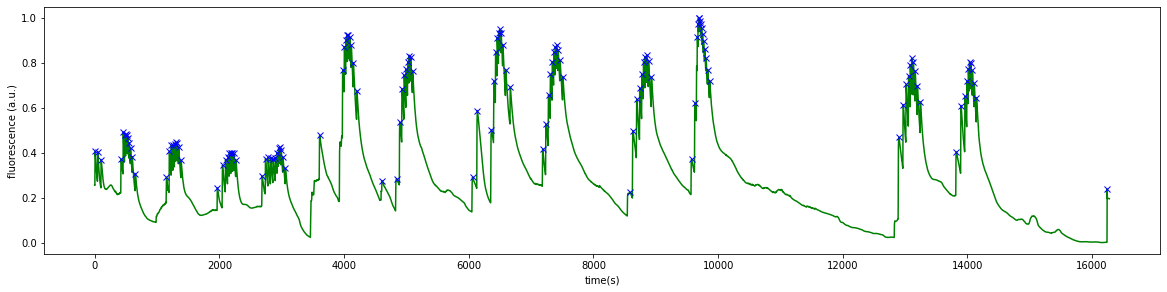

In [248]:
fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(2, 1, 1)
disp.add_fluorescence(ax1, range(len(fluo)), fluo)
disp.add_peaks(ax1, peaks, fluo, 1)
plt.show()

### Count CB spikes and extract periods

In [249]:
# Count the number of CB spikes
spike_counts = []
cb_periods = []
for cluster in pk_clusters:
    spike_counts.append(len(cluster))
    cb_periods.append((cluster[0], cluster[-1]))

In [250]:
elong_periods = []

for j in range(len(cb_periods)-1):
    elong_periods.append((cb_periods[j][1], cb_periods[j+1][0]))

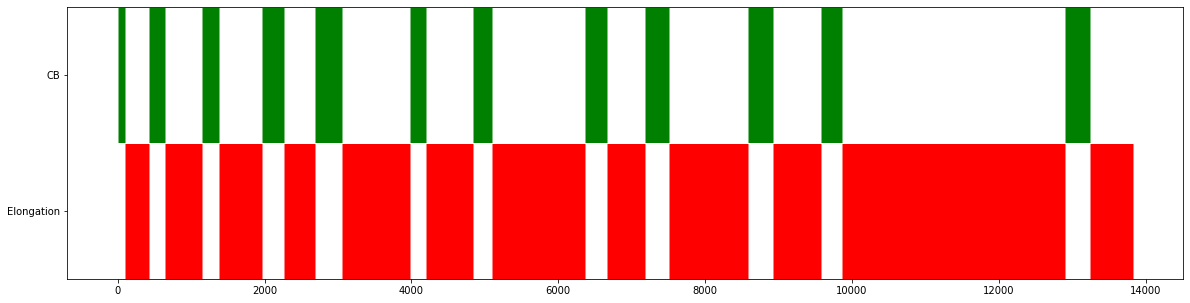

In [251]:
plt.figure(figsize=(20, 5))
for period in elong_periods:
    plt.hlines(1, period[0], period[1], colors='r', linewidth=135)
for period in cb_periods[:-1]:
    plt.hlines(2, period[0], period[1], colors='g', linewidth=135)
plt.yticks([1,2], ['Elongation', 'CB'])
plt.ylim(0.5, 2.5)
plt.show()

### Extract and normalize elongation pieces

In [252]:
LENDIR = "./data/midline/"
LENNAME = "lengths_" + VIDEONAME + ".csv"

In [253]:
# Load midline length
length = pd.read_csv(LENDIR + LENNAME).values.reshape(-1)

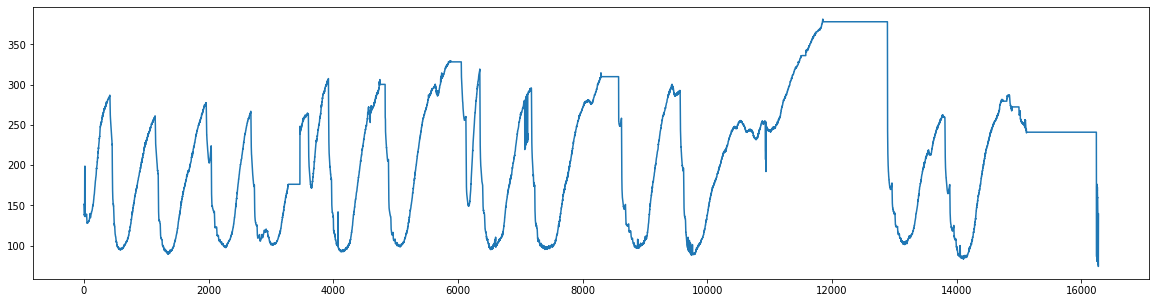

In [254]:
plt.figure(figsize=(20,5))
plt.plot(length)

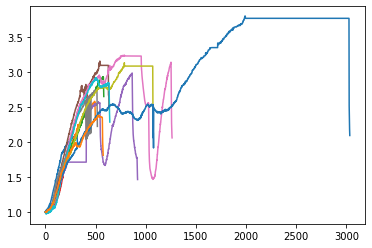

In [255]:
length_pieces = []
length_ratios = []

for period in elong_periods:
    
    len_piece = length[period[0]:period[1]]
    
    # Normalize the piece as ratio
    base = len_piece[0]
    len_piece = [x/base for x in len_piece]
    length_pieces.append(len_piece)
    length_ratios.append(max(len_piece))
    plt.plot(len_piece)

### Save results

In [187]:
results['spikecounts_ratio'].extend([(spike_counts[j], length_ratios[j]) for j in range(len(length_ratios))])
results['length_pieces'].extend(length_pieces)

### Plot results

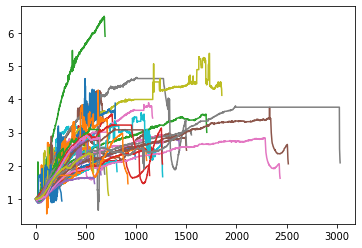

In [240]:
plt.figure()
for piece in results['length_pieces']:
    plt.plot(piece)
plt.show()

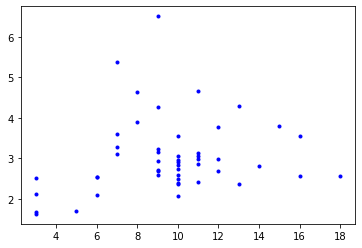

In [241]:
plt.figure()
for pair in results['spikecounts_ratio']:
    plt.plot(pair[0], pair[1], 'b.')
plt.show()